In [1]:
import numpy as np
import tensorflow as tf
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def gauss(x, mu, sigma):
    A = 1/(sigma*np.sqrt(2*np.pi))
    return A*np.exp(-np.power(x-mu,2)/(2*sigma**2))

In [3]:
def bimodal(x, mu1, mu2, sigma1, sigma2):
    return (gauss(x, mu1, sigma1) + gauss(x, mu2, sigma2))/2

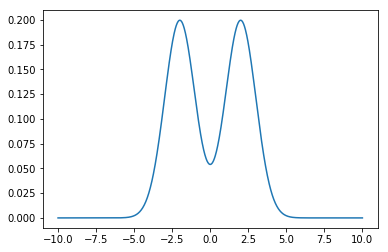

In [29]:
plt.plot(np.linspace(-10,10,1000), bimodal(np.linspace(-10,10,1000),-2, 2, 1, 1))

In [4]:
class Bimodal(scipy.stats.rv_continuous):
    def __init__(self, mu1, mu2, sigma1, sigma2):
        self.params = (mu1, mu2, sigma1, sigma2)
        super(Bimodal, self).__init__()
    def _pdf(self, x):
        return bimodal(x, *self.params)

In [5]:
bi = Bimodal(-2, 2, 1, 1)

In [53]:
data = bi.rvs(size=1000)

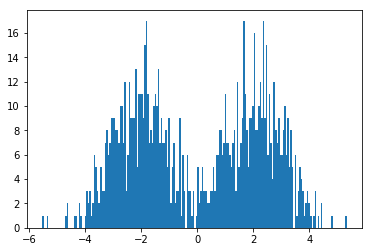

In [33]:
plt.hist(data, 200);

In [6]:
batch_size = 64
updates = 40000
learning_rate = 0.01
noise_range = 5

In [7]:
tf.reset_default_graph()

In [8]:
gen_weights = dict()
gen_weights['w1'] = tf.Variable(tf.random_normal([1,5]))
gen_weights['b1'] = tf.Variable(tf.random_normal([5]))
gen_weights['w2'] = tf.Variable(tf.random_normal([5,1]))
gen_weights['b2'] = tf.Variable(tf.random_normal([1]))

disc_weights = dict()
disc_weights['w1'] = tf.Variable(tf.random_normal([1,10]))
disc_weights['b1'] = tf.Variable(tf.random_normal([10]))
disc_weights['w2'] = tf.Variable(tf.random_normal([10,10]))
disc_weights['b2'] = tf.Variable(tf.random_normal([10]))
disc_weights['w3'] = tf.Variable(tf.random_normal([10,1]))
disc_weights['b3'] = tf.Variable(tf.random_normal([1]))

z_p = tf.placeholder('float', [None, 1])
x_d = tf.placeholder('float', [None, 1])

g_h = tf.nn.softplus(tf.add(
           tf.matmul(z_p, gen_weights['w1']),gen_weights['b1']))
x_g = tf.add(tf.matmul(g_h, gen_weights['w2']), gen_weights['b2'])

def discriminator(x):
    d_h1 = tf.nn.tanh(tf.add(
        tf.matmul(x, disc_weights['w1']), disc_weights['b1']))
    d_h2 = tf.nn.tanh(tf.add(
        tf.matmul(d_h1, disc_weights['w2']),disc_weights['b2']))
    score = tf.nn.sigmoid(tf.add(
        tf.matmul(d_h2, disc_weights['w3']), disc_weights['b3']))
    return score

x_data_score = discriminator(x_d)
x_gen_score = discriminator(x_g)

D_cost = -tf.reduce_mean(tf.log(x_data_score) + tf.log(1.0 - x_gen_score))
G_cost = tf.reduce_mean(tf.log(1.0 - x_gen_score))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
D_optimizer = optimizer.minimize(D_cost, var_list=list(disc_weights.values()))
G_optimizer = optimizer.minimize(G_cost, var_list=list(gen_weights.values()))

In [9]:
def sample_z(size=batch_size):
    return np.random.uniform(-noise_range, noise_range, size=[size,1])
def sample_x(dist, size=batch_size):
    return dist.rvs(size=[size, 1])

In [10]:
sess = tf.Session()
saver = tf.train.Saver()

In [11]:
init = tf.global_variables_initializer()
sess.run(init)

In [12]:
for i in range(updates):
    z_batch = sample_z()
    x_batch = sample_x(bi)
    sess.run(D_optimizer, feed_dict={z_p: z_batch, x_d: x_batch})
    z_batch = sample_z()
    sess.run(G_optimizer, feed_dict={z_p: z_batch})

KeyboardInterrupt: 

In [11]:
saver.save(sess, '/home/alex/MLX/Bimodal/model.ckpt')

In [12]:
#saver.restore(sess, 'model.ckpt')

INFO:tensorflow:Restoring parameters from model.ckpt
